## Figure 1: Human Group Results

This notebook presents group-level analyses of place cell properties in human subjects. It includes:
- Percentage of place cells identified by different statistical methods
- Comparison of place cell detection across brain regions
- The relationship between detection metric and significance classification


In [83]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from convnwb.io import get_files, load_jsons_to_df
from scipy.stats import binom_test
from spiketools.plts.data import plot_hist
from spiketools.plts.annotate import add_vlines
from spiketools.plts.utils import make_grid, get_grid_subplot, save_figure
from spiketools.plts.style import drop_spines
from spiketools.utils.run import create_methods_list

In [84]:
import seaborn as sns
sns.set_context('talk', font_scale=0.9)

In [85]:
import sys
sys.path.append('../code')
from reports import get_significant_percentage,get_agreement_percentage
from plts import plot_percentages

sys.path.append('../scripts')
from settings import PATHS, METHODS

## Load Group Data

In [86]:
results_folder = PATHS['RESULTS'] / 'units_bins'
reports_folder = PATHS['REPORTS'] / 'units_bins'

locations_folder = PATHS['BASE'] / 'localization'/'Loc'
jacksheet_folder = PATHS['BASE'] / 'localization'/'jacksheet'
locations_files = get_files(locations_folder, select='session_data')
locations_files

['session_data.json']

In [87]:
Locations = load_jsons_to_df(locations_files, folder=locations_folder)


In [88]:
results_folder

PosixPath('/Users/weijiazhang/Data/Train/results/units_bins')

In [89]:
res_files = get_files(results_folder,select='json')

In [90]:
all_results = load_jsons_to_df(res_files, folder=results_folder)
all_results.columns

Index(['unit_ind', 'session_id', 'numBins', 'place_bins_20',
       'trial_place_bins_20', 'place_info_20', 'place_anova_20',
       'place_bins_30', 'trial_place_bins_30', 'place_info_30',
       'place_anova_30', 'place_bins_40', 'trial_place_bins_40',
       'place_info_40', 'place_anova_40', 'place_bins_50',
       'trial_place_bins_50', 'place_info_50', 'place_anova_50',
       'place_bins_60', 'trial_place_bins_60', 'place_info_60',
       'place_anova_60'],
      dtype='object')

In [92]:

all_results['firing_rate'] = all_results['place_bins_40'].apply(lambda x: np.mean(x))
all_results['presence_ratio'] = all_results['trial_place_bins_40'].apply(lambda x: np.mean([np.any(np.array(trial) > 0) for trial in x]))

all_results = all_results[all_results['firing_rate'].astype(float) < 20]
all_results = all_results[all_results['firing_rate'].astype(float) > .15]
#all_results = all_results[all_results['presence_ratio'].astype(float) > .2]
# Display the filtered dataframe
print("\nFiltered dataframe shape:", all_results.shape)


Filtered dataframe shape: (307, 25)


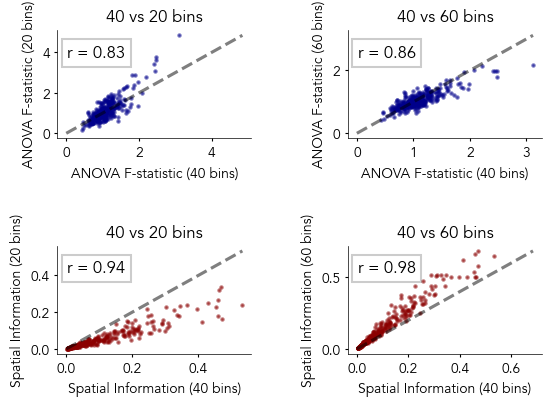

In [101]:
# Create scatter plot comparing ANOVA F-statistics between 20 and 40 bins
grid = make_grid(3, 3, wspace=.5, hspace=1, figsize=(10, 7),
                 )

plt.rcParams.update({
    'font.family': 'Avenir',  # Other options similar to Apple SD Gothic Neo: 'Avenir', 'Helvetica Neue', 'SF Pro Text'
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'legend.fontsize': 6,
    'xtick.labelsize': 10,  # Smaller tick label size
    'ytick.labelsize': 10,  # Smaller tick label size
    'axes.linewidth': 0.5,  # Reduce the thickness of axis lines

    'xtick.major.width': 0.8,  # Thinner x ticks
    'ytick.major.width': 0.8,  # Thinner y ticks
    'xtick.major.size': 2.0,   # Shorter x ticks
    'ytick.major.size': 2.0

})

ax = get_grid_subplot(grid, 0, 0)
ax.scatter(all_results['place_anova_40'], all_results['place_anova_20'], alpha=0.5,color='darkblue',s=3)
ax.plot([0, max(all_results['place_anova_40'].max(), all_results['place_anova_20'].max())], 
         [0, max(all_results['place_anova_40'].max(), all_results['place_anova_20'].max())], 
         'k--', alpha=0.5) # Add diagonal line

ax.set_xlabel('ANOVA F-statistic (40 bins)')
ax.set_ylabel('ANOVA F-statistic (20 bins)') 

ax.set_title('40 vs 20 bins')

# Calculate correlation coefficient
corr = all_results['place_anova_40'].corr(all_results['place_anova_20'])
ax.text(0.05, 0.75, f'r = {corr:.2f}', 
         transform=ax.transAxes, 
         bbox=dict(facecolor='white', alpha=0.2))
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 0, 1)
ax.scatter(all_results['place_anova_40'], all_results['place_anova_60'], alpha=0.5,color='darkblue',s=3)
ax.plot([0, max(all_results['place_anova_40'].max(), all_results['place_anova_60'].max())], 
         [0, max(all_results['place_anova_40'].max(), all_results['place_anova_60'].max())], 
         'k--', alpha=0.5) # Add diagonal line

ax.set_xlabel('ANOVA F-statistic (40 bins)')
ax.set_ylabel('ANOVA F-statistic (60 bins)') 
ax.set_title('40 vs 60 bins')
corr = all_results['place_anova_40'].corr(all_results['place_anova_60'])
ax.text(0.05, 0.75, f'r = {corr:.2f}', 
         transform=ax.transAxes, 
         bbox=dict(facecolor='white', alpha=0.2))
drop_spines(['top', 'right'], ax=ax)


ax = get_grid_subplot(grid,1,0)
ax.scatter(all_results['place_info_40'], all_results['place_info_20'], alpha=0.5,color='darkred',s=3)
ax.plot([0, max(all_results['place_info_40'].max(), all_results['place_info_20'].max())], 
         [0, max(all_results['place_info_40'].max(), all_results['place_info_20'].max())], 
         'k--', alpha=0.5) # Add diagonal line

ax.set_xlabel('Spatial Information (40 bins)')
ax.set_ylabel('Spatial Information (20 bins)') 
ax.set_title('40 vs 20 bins')
drop_spines(['top', 'right'], ax=ax)
corr = all_results['place_info_40'].corr(all_results['place_info_20'])
ax.text(0.05, 0.75, f'r = {corr:.2f}', 
         transform=ax.transAxes, 
         bbox=dict(facecolor='white', alpha=0.2))

ax = get_grid_subplot(grid,1,1)
ax.scatter(all_results['place_info_40'], all_results['place_info_60'], alpha=0.5,color='darkred',s=3)
ax.plot([0, max(all_results['place_info_40'].max(), all_results['place_info_60'].max())], 
         [0, max(all_results['place_info_40'].max(), all_results['place_info_60'].max())], 
         'k--', alpha=0.5) # Add diagonal line

ax.set_xlabel('Spatial Information (40 bins)')
ax.set_ylabel('Spatial Information (60 bins)') 
ax.set_title('40 vs 60 bins')
drop_spines(['top', 'right'], ax=ax)
corr = all_results['place_info_40'].corr(all_results['place_info_60'])
ax.text(0.05, 0.75, f'r = {corr:.2f}', 
         transform=ax.transAxes, 
         bbox=dict(facecolor='white', alpha=0.2))

save_figure('Effect_of_Bin_Size_Scatter',file_path='/Users/weijiazhang/Plots/PLDM/Human',dpi=300)


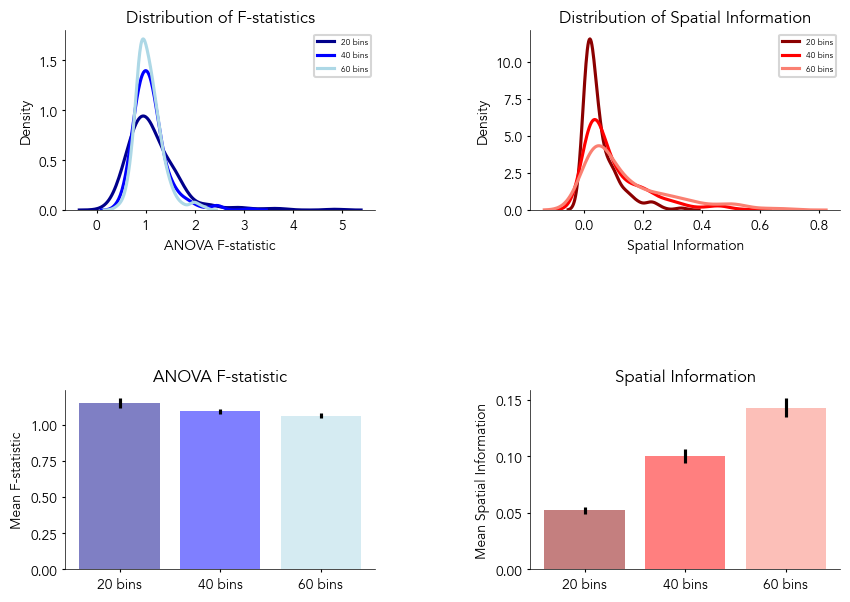

In [100]:
# Create grid for comparing distributions across bin sizes
grid = make_grid(2, 2, wspace=.5, hspace=1, figsize=(10, 7))

plt.rcParams.update({
    'font.family': 'Avenir',
    'font.size': 12,
    'axes.titlesize': 12, 
    'axes.labelsize': 10,
    'legend.fontsize': 6,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 2.0,
    'ytick.major.size': 2.0
})

# Plot ANOVA F-statistic density
ax = get_grid_subplot(grid, 0, 0)
sns.kdeplot(data=all_results['place_anova_20'], ax=ax, color='darkblue', label='20 bins')
sns.kdeplot(data=all_results['place_anova_40'], ax=ax, color='blue', label='40 bins')
sns.kdeplot(data=all_results['place_anova_60'], ax=ax, color='lightblue', label='60 bins')
ax.set_xlabel('ANOVA F-statistic')
ax.set_ylabel('Density')
ax.set_title('Distribution of F-statistics')
ax.legend()
drop_spines(['top', 'right'], ax=ax)

# Plot spatial information density
ax = get_grid_subplot(grid, 0, 1)
sns.kdeplot(data=all_results['place_info_20'], ax=ax, color='darkred', label='20 bins')
sns.kdeplot(data=all_results['place_info_40'], ax=ax, color='red', label='40 bins')
sns.kdeplot(data=all_results['place_info_60'], ax=ax, color='salmon', label='60 bins')
ax.set_xlabel('Spatial Information')
ax.set_ylabel('Density')
ax.set_title('Distribution of Spatial Information')
ax.legend()
drop_spines(['top', 'right'], ax=ax)
# Add summary statistics
ax = get_grid_subplot(grid, 1, 0)
means = [all_results['place_anova_20'].mean(), all_results['place_anova_40'].mean(), all_results['place_anova_60'].mean()]
sems = [all_results['place_anova_20'].std()/np.sqrt(len(all_results)), 
        all_results['place_anova_40'].std()/np.sqrt(len(all_results)),
        all_results['place_anova_60'].std()/np.sqrt(len(all_results))]
ax.bar(['20 bins', '40 bins', '60 bins'], means, yerr=sems, alpha=0.5, color=['darkblue', 'blue', 'lightblue'])
ax.set_ylabel('Mean F-statistic')
ax.set_title('ANOVA F-statistic')
drop_spines(['top', 'right'], ax=ax)

ax = get_grid_subplot(grid, 1, 1)
means = [all_results['place_info_20'].mean(), all_results['place_info_40'].mean(), all_results['place_info_60'].mean()]
sems = [all_results['place_info_20'].std()/np.sqrt(len(all_results)),
        all_results['place_info_40'].std()/np.sqrt(len(all_results)), 
        all_results['place_info_60'].std()/np.sqrt(len(all_results))]
ax.bar(['20 bins', '40 bins', '60 bins'], means, yerr=sems, alpha=0.5, color=['darkred', 'red', 'salmon'])
ax.set_ylabel('Mean Spatial Information')
ax.set_title('Spatial Information')
drop_spines(['top', 'right'], ax=ax)


save_figure('Effect_of_Bin_Size_Distribution',file_path='/Users/weijiazhang/Plots/PLDM/Human',dpi=300)